# Eyesense

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

-Normal (N),
-Diabetes (D),
-Glaucoma (G),
-Cataract (C),
-Age related Macular Degeneration (A),
-Hypertension (H),
-Pathological Myopia (M),
-Other diseases/abnormalities (O)

In [19]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')
from tensorflow.keras.preprocessing import image_dataset_from_directory
from shutil import copy, move
import glob
import pathlib

In [20]:
df = pd.read_csv("raw_data/full_df.csv")

# Preprocess images

In [21]:
dir_path = '../raw_data/raw_data/preprocessed_images/'   #According to my computer.
img_list = os.listdir(dir_path)

In [29]:
data_dir_train = pathlib.Path('data_train')
data_dir_test  = pathlib.Path('data_test')

In [30]:
train_length = len(list(data_dir_train.glob('*/*.jpg')))
test_length  = len(list(data_dir_test.glob('*/*.jpg')))

print(f"Train: {train_length}")
print(f"Test:  {test_length}")

Train: 5757
Test:  635


In [31]:
assert (test_length + train_length)  == len(df)

In [38]:
batch_size = 8
img_height = 256
img_width  = 256

In [45]:
train_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5757 files belonging to 8 classes.
Using 4606 files for training.


In [46]:
val_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5757 files belonging to 8 classes.
Using 1151 files for validation.


In [47]:
#assert train_ds.class_names == test_ds.class_names
class_names = train_ds.class_names
class_names

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal',
 'others']

2025-03-16 13:36:57.987516: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


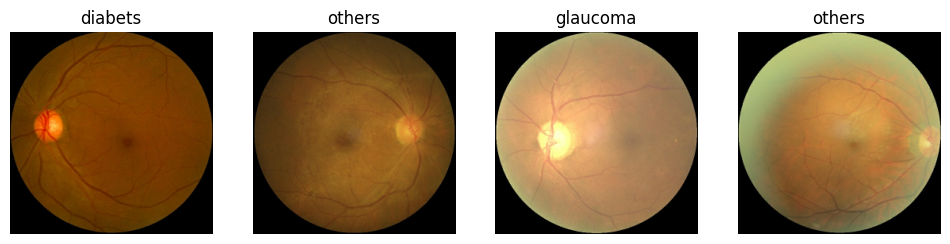

In [48]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [49]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 256, 3)
(8,)


# Model

In [50]:
from tensorflow.keras import layers
from tensorflow.keras import models


def initialize_model():


    model = models.Sequential()
    
    model = tf.keras.Sequential([
          tf.keras.layers.Rescaling(1./255),
          tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Conv2D(32, (4,4), activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(8, activation='softmax')
        ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    ### Model compilation
    model.compile(
          optimizer=optimizer,
          loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics=['accuracy'])
    
    return model

In [54]:
model = initialize_model()
 
#model.summary()

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=2
)

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 1000,
    callbacks = [es],
    verbose = 1
)

Epoch 1/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 77s 147ms/step - accuracy: 0.4166 - loss: 1.6644 - val_accuracy: 0.4506 - val_loss: 1.5825
Epoch 2/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - accuracy: 0.4458 - loss: 1.5748 - val_accuracy: 0.4506 - val_loss: 1.5657
Epoch 3/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - accuracy: 0.4463 - loss: 1.5688 - val_accuracy: 0.4506 - val_loss: 1.5735
Epoch 4/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 75s 147ms/step - accuracy: 0.4425 - loss: 1.5622 - val_accuracy: 0.4506 - val_loss: 1.5482
Epoch 5/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - accuracy: 0.4452 - loss: 1.5551 - val_accuracy: 0.4497 - val_loss: 1.5587
Epoch 6/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - accuracy: 0.4445 - loss: 1.5385 - val_accuracy: 0.4506 - val_loss: 1.5151
Epoch 7/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - accuracy: 0.4484 - loss: 1.5190 - val_accuracy: 0.4506 - val_loss: 1.5400
Epoch 8/1000
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - accuracy: 

In [17]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.autoscale()
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.autoscale()
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

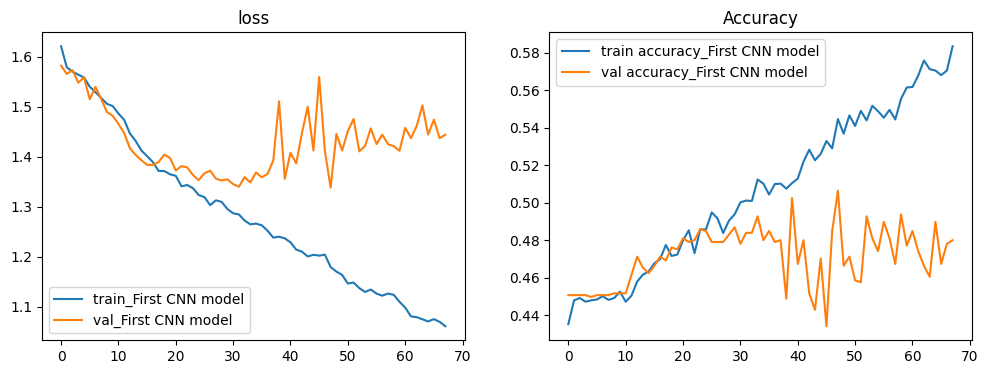

In [18]:
plot_history(history, exp_name= 'First CNN model');